In [9]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [12]:
import dill
dill.dump_session('./data_bruckner/data/notebookData/2_width_vs_CorrLengthEXT-LargeN.db')

In [4]:
import dill
dill.load_session('./data_bruckner/data/notebookData/2_width_vs_CorrLengthEXT-LargeN.db')

In [10]:
def beta_from_corrLength(corrLen):
    beta = np.tan((np.exp(-1./corrLen)))
    return beta

In [11]:
#corrLengths = np.array([0.1,0.5,1.,5,10.,20.,50,100])
corrLengths = np.linspace(2.5,10,2)
#corrLengths = np.array([1,1.5,2,2.5,3])
beta = beta_from_corrLength(corrLengths)
print beta
print corrLengths

[ 0.79277524  1.27275433]
[  2.5  10. ]


In [12]:
#Defining Parameters
Num_configs = 25000
Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
N           = corrLengths*30 #The 30 factor was obtained by previous simulations where the system performed well with this sytems size
N           = N*0 + 100*10

print N

for i in np.arange(len(N)):
    N[i] = np.int(max(30,np.int(N[i]))) # We fix the minimum number of spins to 30

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)
print(Nstep)

[ 1000.  1000.]
[528 848]


## True Error bars with multiple runs of the data generation and fitting

In [ ]:
#%%capture captX

Xdata_big    = []
Xresults_big = []

#XBM      = []
#Xdata    = []
Xresults = []
XRBM     = []

Num_reps = 1

for j in range(Num_reps):
    
    #XBM      = []
    #Xdata    = []
    Xresults = []
    XRBM     = []
    
    for i in np.arange(len(beta)):
        #Generate spins using Gibbs Sampling MCMC
        #XBM.append(bm.BM(N=N[i],nature='Spin'))

        #Define Couplings
        #XBM[i].layer.couplings =  beta[i]*(np.eye(N=N[i],k=1) + np.eye(N=N[i],k=-1) )
        #XBM[i].layer.couplings[0,-1] += beta[i]
        #XBM[i].layer.couplings[-1,0] += beta[i]

        #Generating the ising model data
        #Xdata.append(XBM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

        #Train the model
        XRBM.append(rbm.RBM(visible = 'Spin', n_v=N[i], n_h = 1, hidden = 'Spin',zero_field = True))
        Xresults.append(XRBM[i].fit(Xdata[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=1000,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))
        
    Xdata_big.append(Xdata)
    Xresults_big.append(Xresults)

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

Starting epoch 194
Starting epoch 195
Starting epoch 196
Starting epoch 197
Starting epoch 198
Starting epoch 199
Starting epoch 200
Starting epoch 201
Starting epoch 202
Starting epoch 203
Starting epoch 204
Starting epoch 205
Starting epoch 206
Starting epoch 207
Starting epoch 208
Starting epoch 209
Starting epoch 210
Starting epoch 211
Starting epoch 212
Starting epoch 213
Starting epoch 214
Starting epoch 215
Starting epoch 216
Starting epoch 217
Starting epoch 218
Starting epoch 219
Starting epoch 220
Starting epoch 221
Starting epoch 222
Starting epoch 223
Starting epoch 224
Starting epoch 225
Starting epoch 226
Starting epoch 227
Starting epoch 228
Starting epoch 229
Starting epoch 230
Starting epoch 231
Starting epoch 232
Starting epoch 233
Starting epoch 234
Starting epoch 235
Starting epoch 236
Starting epoch 237
Starting epoch 238
Starting epoch 239
Starting epoch 240
Starting epoch 241
Starting epoch 242
Starting epoch 243
Starting epoch 244
Starting epoch 245
Starting epo

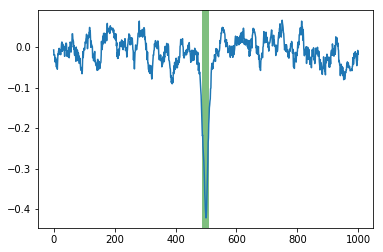

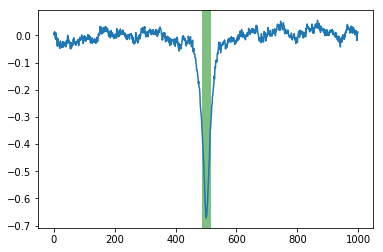

In [16]:
import peakWidth
XFWHM_avg = []
XFWHM_error = []

for i in np.arange(len(beta)):
    
    t1 = np.zeros(Num_reps)
    
    for j in range(Num_reps):
        t1[j] = np.array(peakWidth.peakWidth(weight=np.array(Xresults_big[j][i]['W'])[-1,0,:],plot=True))
        
    XFWHM_avg.append(np.mean(t1))
    XFWHM_error.append(np.std(t1))

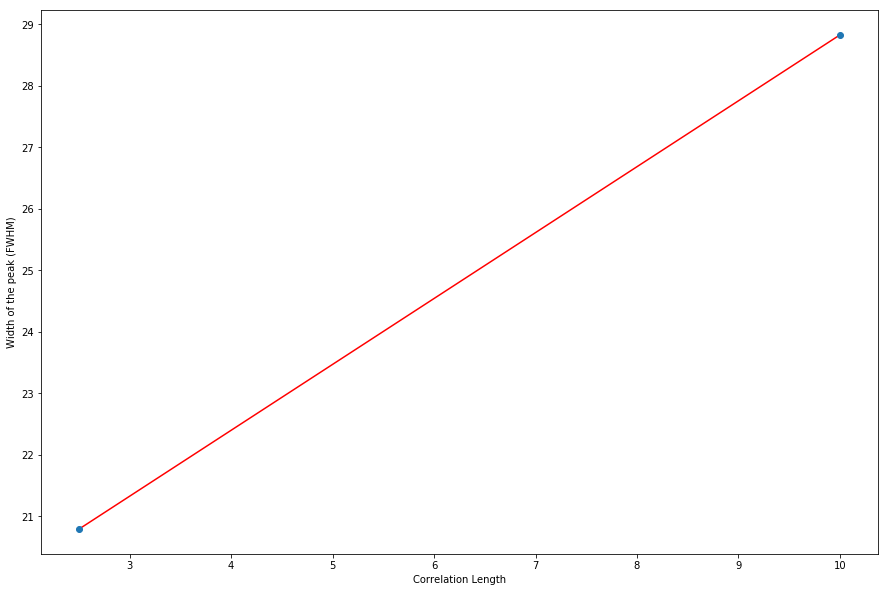

In [17]:
#Plot FWHM as a function of the correlation length
import numpy as np

plt.figure(figsize=(15,10))
Xfit = np.polyfit(corrLengths,XFWHM_avg, deg=1)
plt.plot(corrLengths, Xfit[0] * corrLengths + Xfit[1], color='red')
plt.errorbar(corrLengths,XFWHM_avg,yerr=XFWHM_error,xlolims=0,fmt='o',ecolor='g')
plt.xlabel('Correlation Length')
plt.ylabel('Width of the peak (FWHM)')
plt.show()

In [3]:
#Plot FWHM as a function of the correlation length
import numpy as np

plt.figure(figsize=(15,10))
Xfit = np.polyfit(corrLengths,XFWHM_avg, deg=1)
plt.plot(corrLengths, Xfit[0] * corrLengths + Xfit[1], color='red')
plt.errorbar(corrLengths,XFWHM_avg,yerr=XFWHM_error,xlolims=0,fmt='o',ecolor='g')
plt.xlabel('Correlation Length of the ising model (in number of visible units)',fontsize=20)
plt.ylabel('Width of the peak (in number of visible units)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

NameError: name 'corrLengths' is not defined